In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import torch
import scgen
from feature_attribution_sc.explainers.mask import mask, generate_rankings
from feature_attribution_sc.models.scgen_models import SCGENCustom

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-03-14 09:41:26.640374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-14 09:41:26.640432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-14 09:41:26.640437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing librari

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path='/home/yuge/feature-attribution-sc'

feature_importance_files = [
    f'{data_path}/outputs/baselines/task1_random.csv',
    f'{data_path}/outputs/differential_expression/task1_DE_control.csv',  # these are way slower for some reason???
    f'{data_path}/outputs/expected_gradients/task1_absolute_expected_grads_v2.csv'
]

thresholds = list(range(0, 100, 10))

In [4]:
adata = sc.read(f'{data_path}/datasets/2301_scgen_norman19.h5ad')

Look at the sparsity before any masking.

In [5]:
sparsity_before = adata.X.nnz / (adata.shape[0] * adata.shape[1])
sparsity_before

0.34281408849164346

Pull out the tensor form of the data for passing to the model manually.

In [6]:
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
model = scgen.SCGEN(adata)

In [7]:
batch_size = adata.shape[0]
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

Mask data according to a feature importance ranking, across multiple thresholds.

In [8]:
def generate_masked_inputs(rankings, gene_indices, df, thresholds):
    """Returns the masked inputs given rankings from an attribution file.
    
    Masking can take a while to iterate over all tensors.
    
    Params
    ------
    thresholds : list of percentages at which to remove features
    """
    incremental_sparsity = []
    masked_inputs = {}
    for threshold in thresholds:
        t = float(threshold)/100
        print(t)
        masked_inpt = mask(
            batch['X'], batch['batch'], df, rankings, gene_indices, threshold=t)

        # store input for later use
        masked_inputs[f'masked_{threshold}'] = masked_inpt

        # record the sparsity for plotting. only applicable if we're masking with zeroes
        sparsity_after = np.count_nonzero(masked_inputs[f'masked_{threshold}']) / (adata.shape[0] * adata.shape[1])
        incremental_sparsity.append((t, sparsity_after))
        
    return masked_inputs, incremental_sparsity

/home/yuge/feature-attribution-sc/outputs/baselines/task1_random.csv
Only using attributions for 880 genes.
Generating rankings for 107 labels and 880 features.
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
/home/yuge/feature-attribution-sc/outputs/differential_expression/task1_DE_control.csv
Only using attributions for 880 genes.
Generating rankings for 107 labels and 880 features.
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
/home/yuge/feature-attribution-sc/outputs/expected_gradients/task1_absolute_expected_grads_v2.csv
Only using attributions for 880 genes.
Generating rankings for 107 labels and 880 features.
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


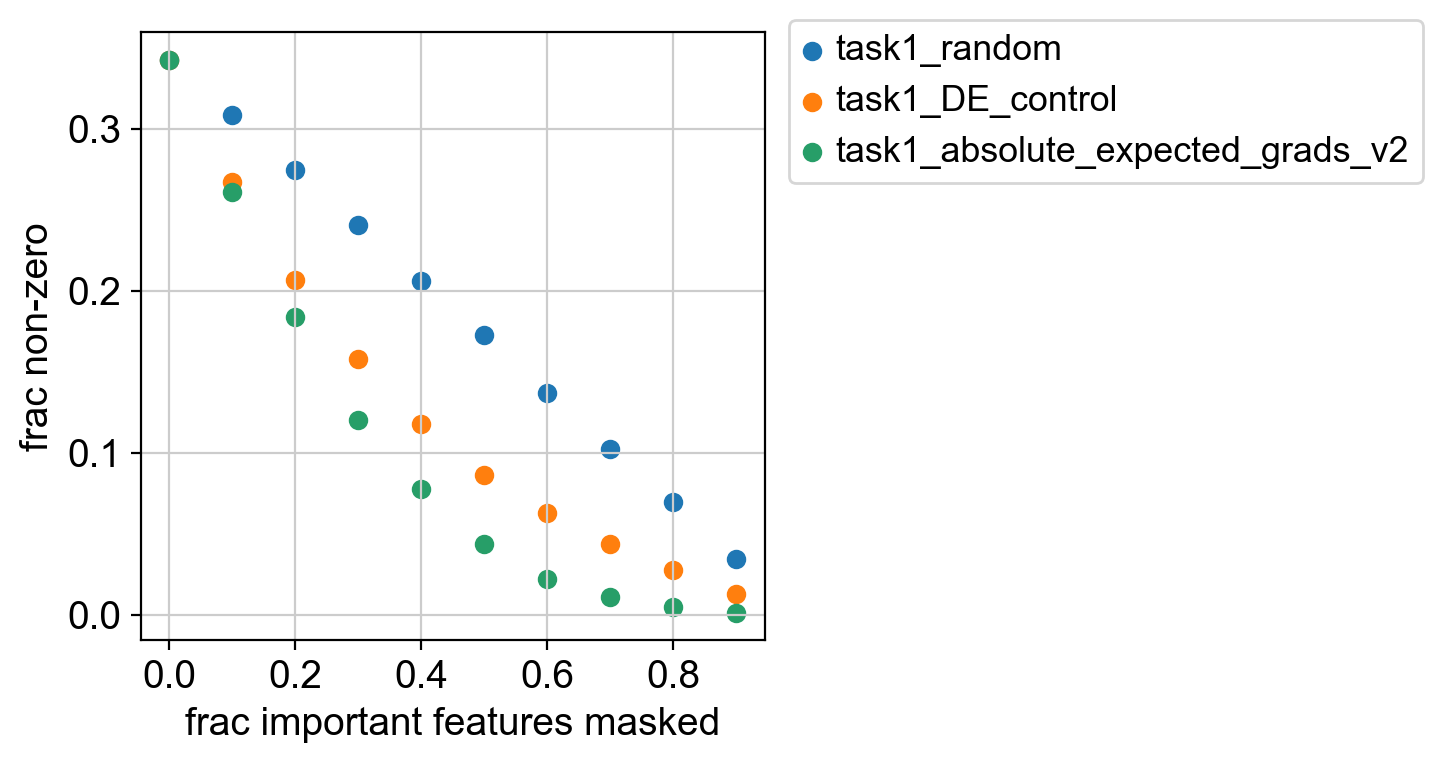

CPU times: user 3min 40s, sys: 9.74 s, total: 3min 50s
Wall time: 3min 34s


In [9]:
%%time
attribution_masks = {}
for feature_importance in feature_importance_files:
    
    print(feature_importance)
    attrib_df = pd.read_csv(feature_importance)
    
    # reverse order for DE
    if 'differential_expression' in feature_importance:
        attrib_df[attrib_df.columns[1:]] *= -1
    
    n_features = attrib_df.shape[0]
    if n_features < adata.shape[1]:
        raise ValueError(
            f"Attributions only calculated for {n_features} genes but adata has {adata.shape[1]}")
    elif n_features > adata.shape[1]:
        print(f'Only using attributions for {adata.shape[1]} genes.')
        attrib_df = attrib_df.set_index('gene_symbols').loc[adata.var_names].reset_index()
    
    rankings, gene_indices = generate_rankings(attrib_df)  # probably should generate gene indices from adata or idk?
    attribution_masks[feature_importance.split("/")[-2]], incremental_sparsity = \
        generate_masked_inputs(rankings, gene_indices, attrib_df, thresholds)
    
    x, y = zip(*incremental_sparsity)
    plt.scatter(x, y, label=feature_importance.split('/')[-1].split('.')[0])

plt.ylabel('frac non-zero')
plt.xlabel('frac important features masked')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.show()

### Pass to an existing model

In [10]:
file = 'scgen_norman19_model0_random_v2'
model = scgen.SCGEN.load(f'{data_path}/models/{file}', adata=adata)
model

INFO     File                                                                                
         /home/yuge/feature-attribution-sc/models/scgen_norman19_model0_random_v2/model.pt   
         already downloaded                                                                  


SCGEN Model with the following params: 
n_hidden: 400, n_latent: 30, n_layers: 2, dropout_rate: 0.2
Training status: Trained

In [11]:
%%time
for k, masks_dict in attribution_masks.items():
    for threshold in thresholds:
        
        new_batch = batch.copy()
        new_batch['X'] = masks_dict[f'masked_{threshold}']

        adata.layers[f'{k}_masked_{threshold}_pred'] = \
            model.module.forward(new_batch, compute_loss=False)[1]['px'].detach().numpy()

CPU times: user 4min 2s, sys: 1min 8s, total: 5min 10s
Wall time: 14.4 s


#### Evaluate

In [12]:
example_pert = 'KLF1'  # condition with the most occurrences

TODO: run the full 30min diffexp when you have time

In [13]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['control', example_pert])]
sc.tl.rank_genes_groups(ctrl_adata, groupby='perturbation_name', reference='control', method='wilcoxon')

diff_genes = ctrl_adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

['TMSB10' 'HBZ' 'PNMT' 'KLF1' 'HBG2' 'HBA1' 'HBG1' 'EMP3' 'ANXA2' 'BLVRB']


In [14]:
pred = adata[adata.obs.perturbation_name == example_pert]
pred.obs['perturbation_name'] = 'pred'

pred.var_names_make_unique()
ctrl_adata.var_names_make_unique()

599963.7
557374.1


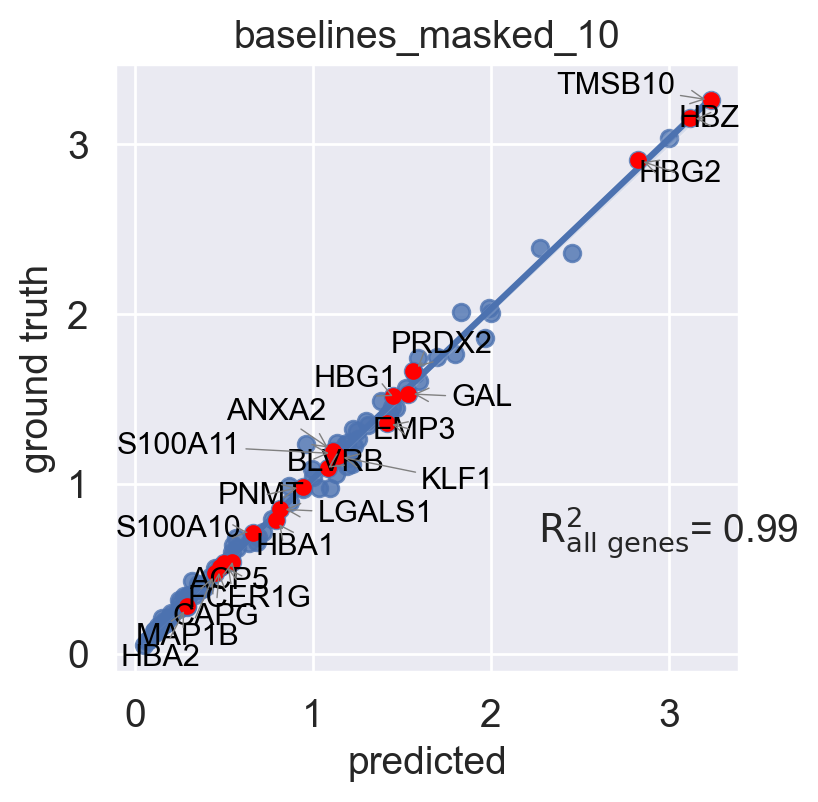

504254.72
454899.56
401404.5


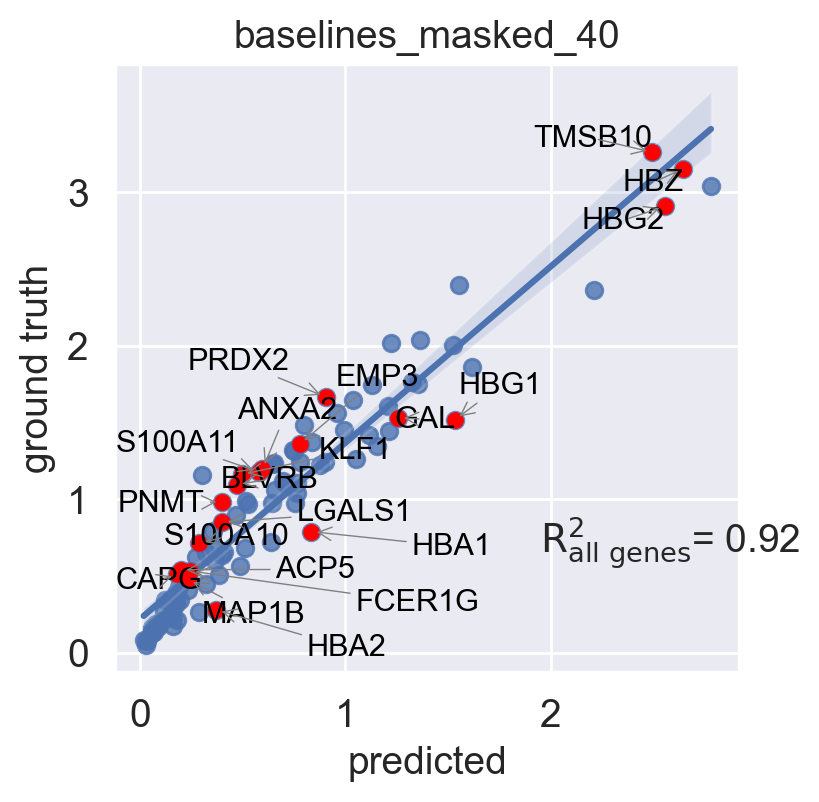

349990.06
270781.94
226264.56
189643.14
161980.77


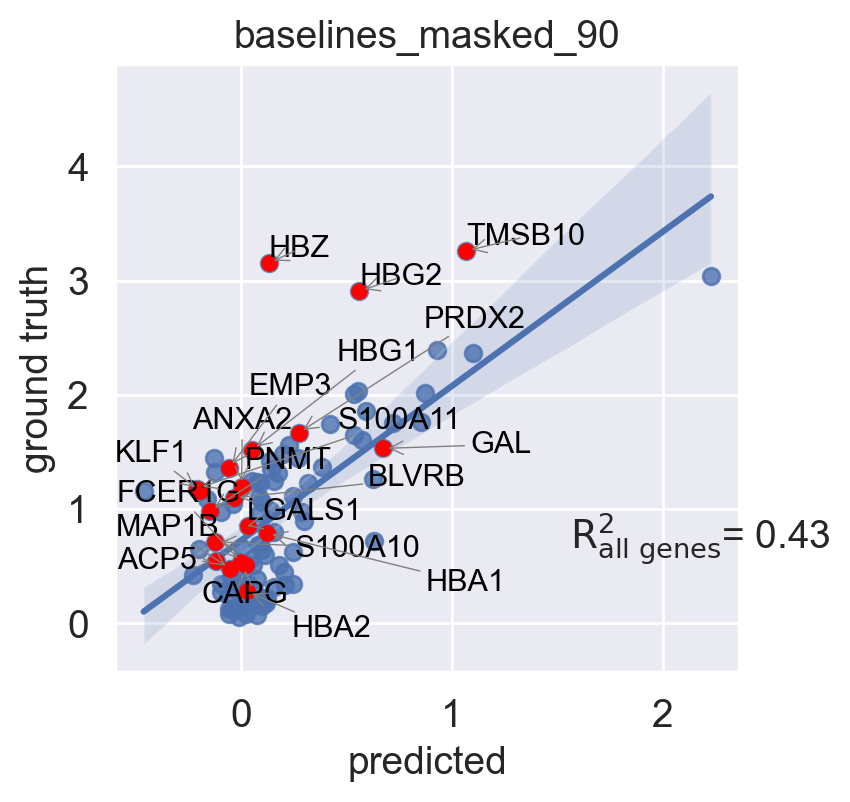

599960.1
398713.3


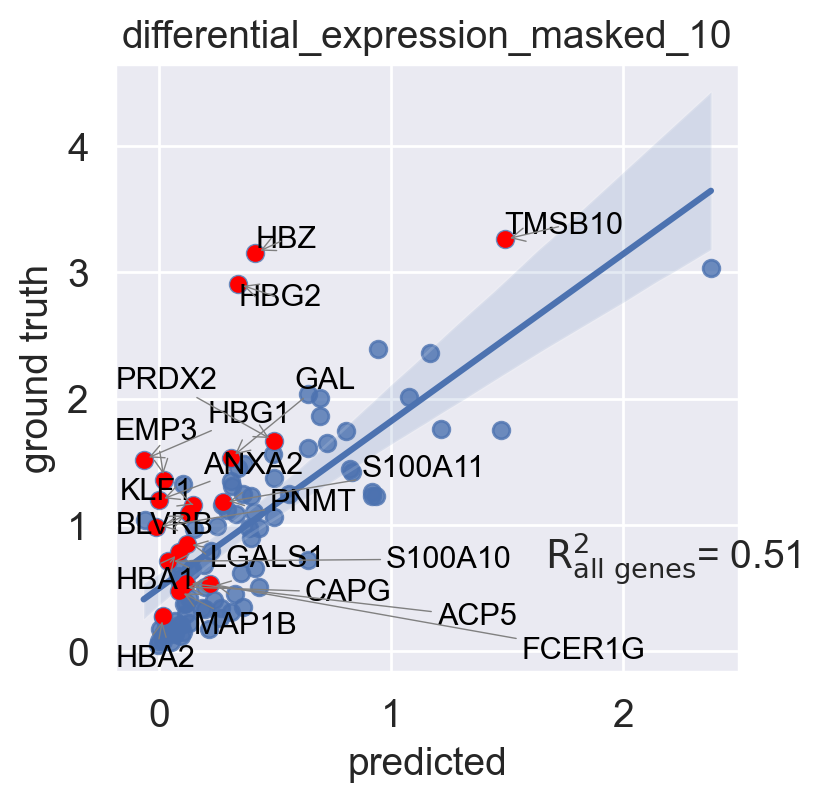

291105.72
249111.78
209542.17


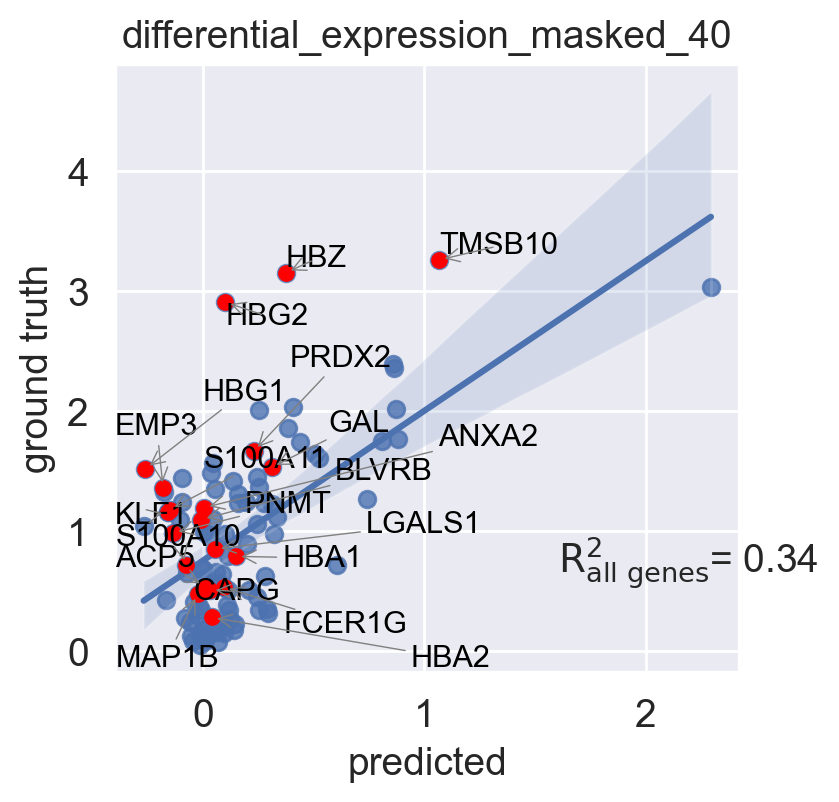

178012.77
166753.95
146579.64
142285.12
137989.05


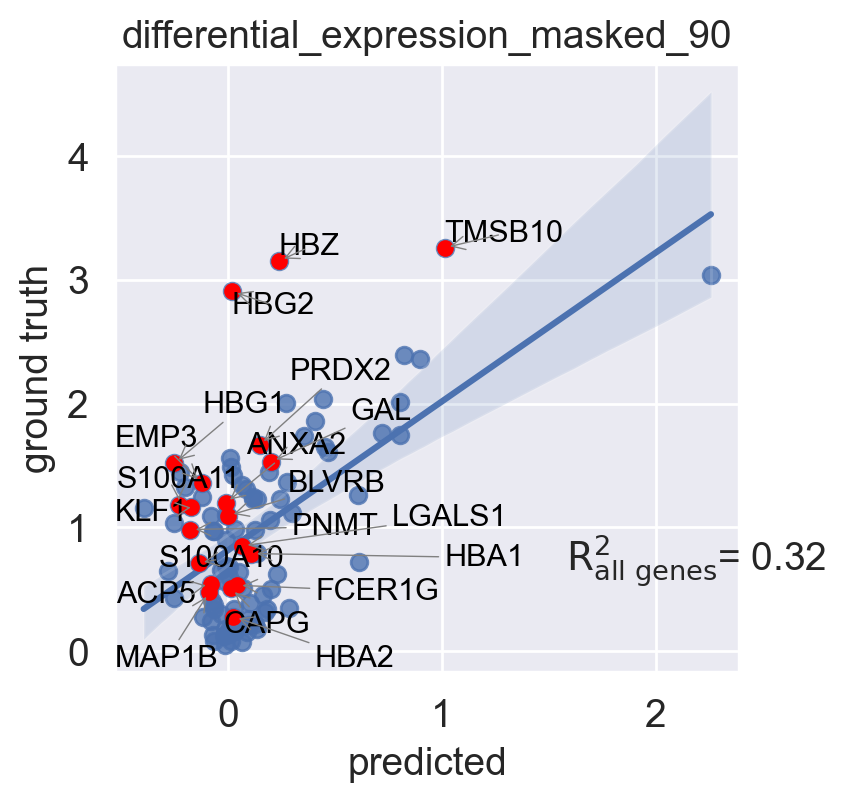

599961.94
387569.0


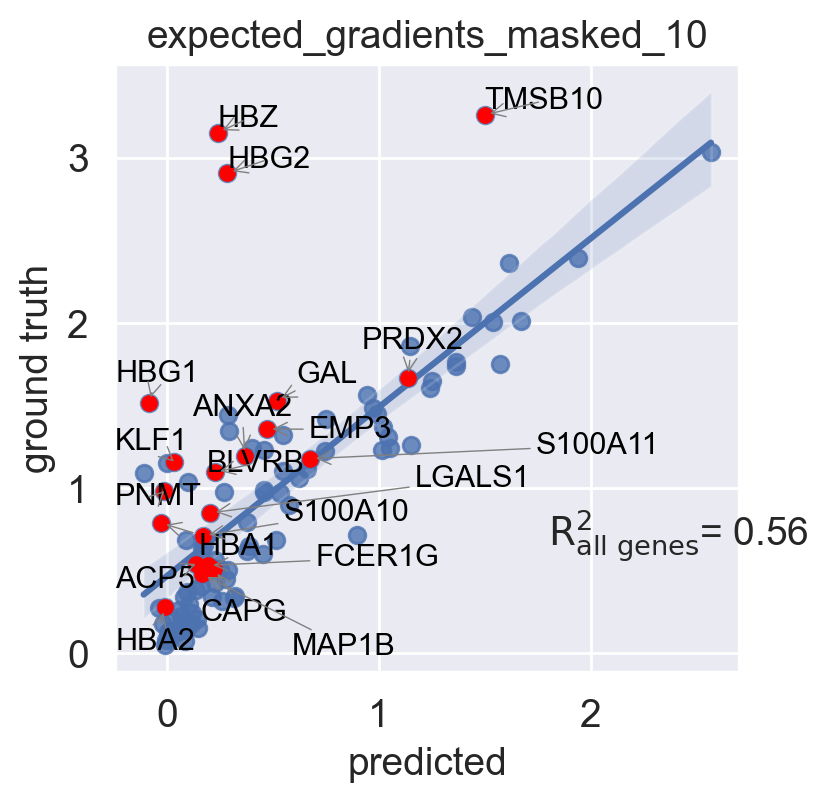

228538.7
171298.11
149492.8


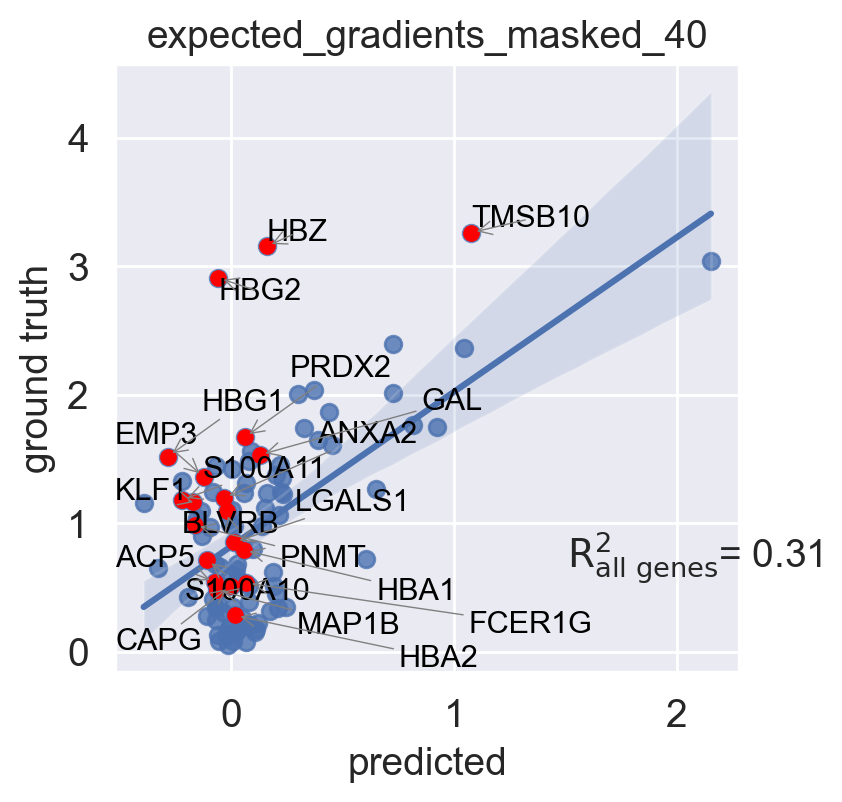

138191.27
133752.86
132639.73
132462.66
132588.81


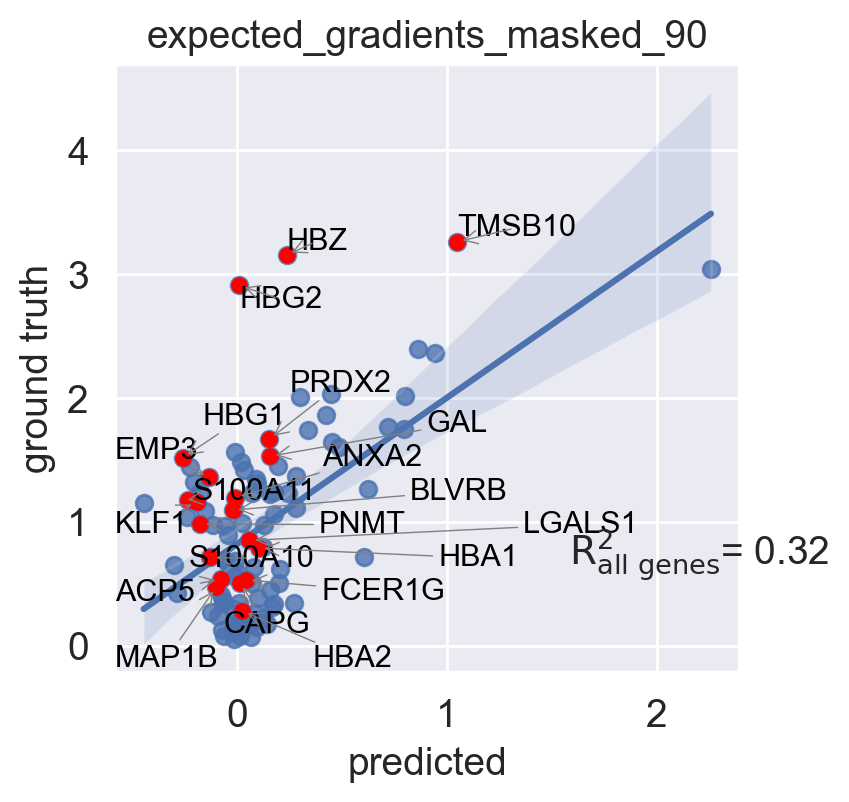

In [15]:
perf_from_mask = {}
for k in attribution_masks.keys():
    r2s = []
    for threshold in thresholds:
        pred.X = pred.layers[f'{k}_masked_{threshold}_pred']
        print(pred.X.sum())
        eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]

        show = False
        if threshold in [10, 40, 90]:
            show = True
        
        r2_value = model.reg_mean_plot(
            eval_adata,
            axis_keys={'x': 'pred', 'y': example_pert},
            gene_list=diff_genes[:20],
            labels={'x': 'predicted', 'y': 'ground truth'},
            show=show,
            legend=False,
            title = f'{k}_masked_{threshold}'
        )
        r2s.append((threshold, r2_value))
    perf_from_mask[k] = r2s

We see here that we end up with a problem which ROAR described - when masking with baseline zeroes, the resulting vectors are actually out of distribution and therefore there is a significant performance decrease even for the random result. It's not a big deal because we still use random as the baseline for performance degredation, but nonetheless we might miss out on some models which pick out correlated structures vs. causal structures.

In [16]:
pd.DataFrame(r2s, columns=['percent features masked', f'R2_{example_pert}']).set_index('percent features masked')

,R2_KLF1
percent features masked,
0,0.997675
10,0.558185
20,0.367551
30,0.304823
40,0.311405
50,0.307259
60,0.310159
70,0.311759
80,0.313603


Text(0.5, 1.0, 'Expected Gradients')

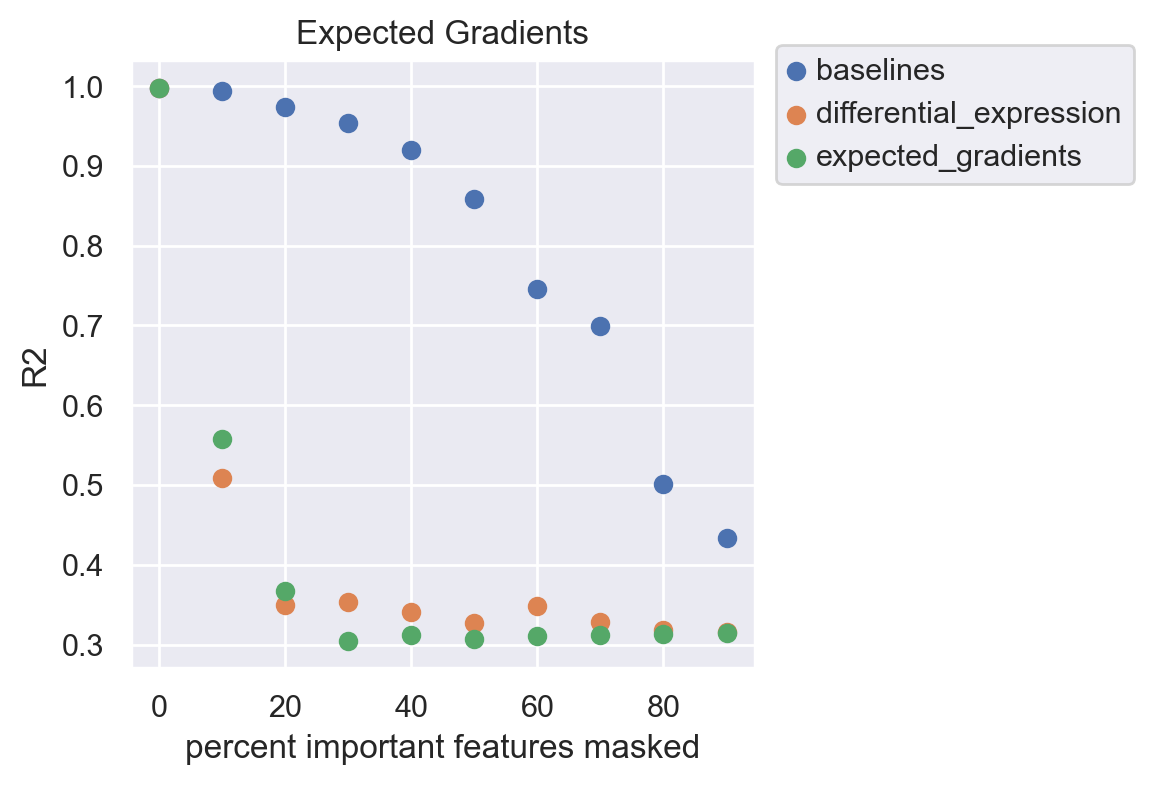

In [17]:
for k, r2s in perf_from_mask.items():
    x, y = zip(*r2s)
    plt.scatter(x, y, label=k)
plt.ylabel('R2')
plt.xlabel('percent important features masked')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.title('Expected Gradients')